<a href="https://colab.research.google.com/github/mferri17/amazon-reviews-sentiment-network-analysis/blob/master/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews Sentiment Analysis - Ferri Marco, Basso Matteo

This project aims to experiment with sentiment analysis on [Amazon Reviews](http://jmcauley.ucsd.edu/data/amazon/) in order to build a "rating" prediction model based on text analysis.

## Dataset

### Dependencies

In [0]:
import os
import gzip
import fileinput
import sys
import datetime
import io
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading


Util functions to read from JSON and convert into pandas dataframe:

In [0]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):      
  basepath = r"datasets\amazon-5-core"
  df = getDF(os.path.join(basepath, dataset))
  return df
  
def download_dataset(dataset):
  request = urllib.request.Request('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/' + dataset)
  request.add_header('Accept-encoding', 'gzip')
  response = urllib.request.urlopen(request)
  buf = io.BytesIO(response.read())
  file = gzip.GzipFile(fileobj=buf)
  df = []
  for line in file:
    df.append(eval(line))
  return pd.DataFrame(df)

Reading from JSON

In [0]:
#%time dfull = read_dataset("reviews_Video_Games_5.json.gz")
%time dfull = download_dataset('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

CPU times: user 13.4 s, sys: 500 ms, total: 13.9 s
Wall time: 22.6 s


#### Reading performance

!pip install py-heat-magic
%load_ext heat

%%heat
import os
import gzip
import fileinput
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):
    basepath = r"datasets\amazon-5-core"
    df = getDF(os.path.join(basepath, dataset))
    return df

dfull = read_dataset("reviews_Video_Games_5.json.gz")

![reading performances](https://github.com/mferri17/amazon-reviews-sentiment-network-analysis/blob/master/docs/images/00_dataset_reading_performances.png?raw=true)

---

###  Description

#### Schema

In [0]:
print("(rows, cols) = ", dfull.shape)

(rows, cols) =  (278677, 9)


In [0]:
dfull = dfull.rename(index=str, columns={"asin": "productID", 
                                         "reviewerID": "userID", 
                                         "reviewerName": "userName",
                                         "reviewText": "text",
                                         "overall": "rating"})

In [0]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278677 entries, 0 to 278676
Data columns (total 9 columns):
productID         278677 non-null object
helpful           278677 non-null object
rating            278677 non-null float64
text              278677 non-null object
reviewTime        278677 non-null object
userID            278677 non-null object
userName          278225 non-null object
summary           278677 non-null object
unixReviewTime    278677 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 21.3+ MB


In [0]:
dfull.head(3)

,productID,helpful,rating,text,reviewTime,userID,userName,summary,unixReviewTime
0,0000031887,"[0, 0]",5.0,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5.0,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5.0,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600


#### Columns analysis

##### Users and products

In [0]:
(rows,cols) = dfull.shape
n_users = dfull['userID'].nunique()
n_products = dfull['productID'].nunique()
print("Number of REVIEWS: ", rows)
print("Number of USERS: ", n_users)
print("Number of PRODUCTS: ", n_products)
print("Average REVIEWS PER USER: ", rows/n_users)
print("Average REVIEWS PER PRODUCT: ", rows/n_products)

Number of REVIEWS:  278677
Number of USERS:  39387
Number of PRODUCTS:  23033
Average REVIEWS PER USER:  7.075354812501587
Average REVIEWS PER PRODUCT:  12.099031823904832


##### Datetime

In [0]:
dfull['date'] = pd.to_datetime(dfull['unixReviewTime'],unit='s')
print("First date: ", min(dfull['date']))
print("Last date: ", max(dfull['date']))

First date:  2003-03-29 00:00:00
Last date:  2014-07-23 00:00:00


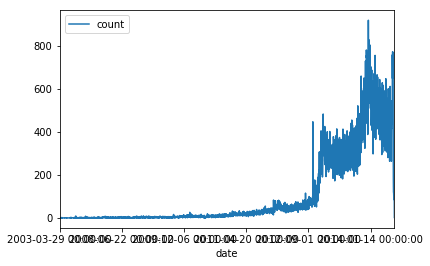

In [0]:
date_grouping = dfull.groupby('date').count()[['rating']].sort_values('date', ascending=True)
date_grouping = date_grouping.rename(index=str, columns={"rating": "count"})
date_grouping.plot()

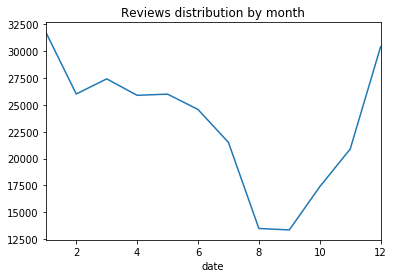

In [0]:
dfull.groupby(dfull['date'].dt.month).count()['rating'].plot(title='Reviews distribution by month')

While people write more reviews during Christmas time and spring, September and October are the months with fewest reviews. Also, very little reviews are found during weekends. However, rating distribution has **no** changes during different date periods (*not showed here, but checked*).

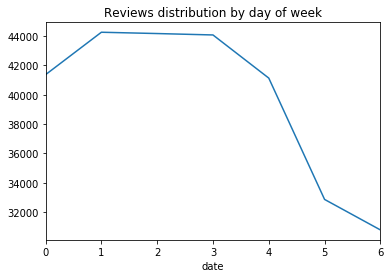

In [0]:
dfull.groupby(dfull['date'].dt.weekday).count()['rating'].plot(title='Reviews distribution by day of week')

In [0]:
# rating distribution for different time slices
# dfull[dfull['date'].dt.weekday == 1]['rating'].hist()
# dfull[dfull['date'].dt.weekday == 6]['rating'].hist()
# dfull[dfull['date'].dt.month == 1]['rating'].hist()
# dfull[dfull['date'].dt.month == 8]['rating'].hist()

##### Rating

In [0]:
print("Average rating: ", dfull['rating'].mean())

Average rating:  4.245133254628118


Rating distribution


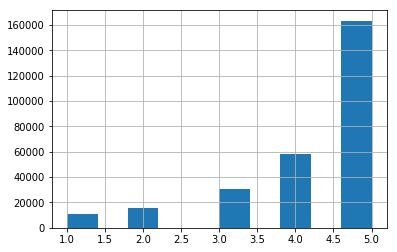

In [0]:
print("Rating distribution")
dfull['rating'].hist()

### Manipulation

#### Rejecting columns

In [0]:
dfull = dfull.drop(['helpful', 'reviewTime', 'unixReviewTime', 'userName'], axis = 1)

#### Binarization

Since target variable (`rating`) is strongly unbalanced between low and high values, it is preferable to reduce the problem from multi-class to binary. Later on, some technique to manage unbalancement will be applied to the dataset, in order to fill the gap between the two binary classes.


In [0]:
dfull['sentiment'] = ['positive' if r > 3 else 'negative' for r in dfull['rating']]

print("Sentiment count")
dfull['sentiment'].value_counts()

Sentiment count


positive    221597
negative     57080
Name: sentiment, dtype: int64

***

## Sentiment Analysis

### Dependencies

In [0]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')


from PIL import Image
from wordcloud import WordCloud

import collections
import itertools


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Text pre-processing

#### Tokenization

Default tokenizers have weird behaviour with puntctuation, numbers and english contractions, hence a custom Regex-based tokenizer has been chosen. Working example below.

In [0]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[^\d\W][\w\']*') # preserve alphabetic words (not numbers) and contractions

#### Stopwords removing

The original stopwords list from NLTK is too aggresive for this use case. Then, stopwords list has been customized with the words below.

Words "not" and "but" are not included in the list, because they could be important to determine negative class membership.

In [0]:
#stopset = set(stopwords.words('english')) # too aggressive

stopset = {
    'one',
    'a', 'ain', 'and', 'any', 'are', 'as', 'at', 
    'be', 'because', 'being', 'between', 'both', 'by', 
    'doing', 'during', 'each', 'few', 'for', 'from', 'further', 
    'has', 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 
    'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 
    'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'my', 'myself', 
    'now', 'o', 'of', 'off', 'on', 'once', 'or', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 
    're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'so', 'some', 'such', 
    't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 
    'there', 'these', 'they', 'this', 'those', 'through', 'to', 'until', 'up', 've', 
    'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'with', 
    'y', 'you', "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'}

print("Stopwords (%.0f): " % len(stopset), list(stopset))

Stopwords (116):  ['there', 'up', 'one', 'then', 'is', 'by', 'their', 'which', 'once', 'he', 'hers', 'during', 'they', 'you', 'her', 'where', 'have', 'she', 's', 'with', 'himself', 'when', 'them', 'haven', "you've", 'ours', 'ourselves', 'further', 'into', 'his', 'itself', 'from', 'ma', 'being', "that'll", 'ain', 'than', 'or', 'a', 'such', 've', 'what', "it's", 'out', 'are', 'whom', 'yourselves', 'at', 'those', 'few', 'same', 'in', 'why', 'some', 'themselves', 'me', "haven't", 'while', 'the', 'and', 'for', 'my', 'now', 'i', 'shan', 're', 'if', 'm', 'these', 'has', 'as', "she's", 'own', 'should', "should've", 'doing', 'each', 'myself', 'our', 't', 'that', 'until', 'over', 'who', 'be', 'to', 'y', 'of', 'was', 'herself', 'll', 'both', 'were', 'having', 'through', 'your', 'him', 'how', 'we', 'its', 'between', 'here', 'it', 'just', 'this', 'because', 'off', 'yourself', "you're", 'theirs', 'yours', "shan't", 'on', 'so', 'any', 'o']


#### Stemming

The default english stemmer is enough for this use case. However, it is not very influent on prediction performance and it has to be noticed that on large datasets it requires very much RAM. That is why stemming will not probably be used.

In [0]:
stemmer = SnowballStemmer('english')

#### Full example

In [0]:
print("TEXT ANALYSIS EXAMPLE")

text = "Hi! This... isn't a beautiful sentence with some interesting $70 and €5,50 features like people's names and Mr. Fox thoughts for number such as 23, 4 and 7 or peer2peer and wi-fi with snake_case but not kebab-case."
print("Text:\t\t", text) # original

# tokenizing
tokens = tokenizer.tokenize(text)
print("Tokenized:\t", tokens)

# lowercasing
tokens = [t.lower() for t in tokens] 
print("Lowercased:\t", tokens)

# removing stopwords
tokens = [t for t in tokens if not t in stopset]  
print("No stopwords:\t", tokens)

# stemming
tokens = [stemmer.stem(t) for t in tokens]
print("Stemmed:\t", tokens)

TEXT ANALYSIS EXAMPLE
Text:		 Hi! This... isn't a beautiful sentence with some interesting $70 and €5,50 features like people's names and Mr. Fox thoughts for number such as 23, 4 and 7 or peer2peer and wi-fi with snake_case but not kebab-case.
Tokenized:	 ['Hi', 'This', "isn't", 'a', 'beautiful', 'sentence', 'with', 'some', 'interesting', 'and', 'features', 'like', "people's", 'names', 'and', 'Mr', 'Fox', 'thoughts', 'for', 'number', 'such', 'as', 'and', 'or', 'peer2peer', 'and', 'wi', 'fi', 'with', 'snake_case', 'but', 'not', 'kebab', 'case']
Lowercased:	 ['hi', 'this', "isn't", 'a', 'beautiful', 'sentence', 'with', 'some', 'interesting', 'and', 'features', 'like', "people's", 'names', 'and', 'mr', 'fox', 'thoughts', 'for', 'number', 'such', 'as', 'and', 'or', 'peer2peer', 'and', 'wi', 'fi', 'with', 'snake_case', 'but', 'not', 'kebab', 'case']
No stopwords:	 ['hi', "isn't", 'beautiful', 'sentence', 'interesting', 'features', 'like', "people's", 'names', 'mr', 'fox', 'thoughts', 'numb

#### Processing dataset

In [0]:
def text_processing(field):
  normalized = dfull[field]
  normalized = normalized.apply(tokenizer.tokenize)
  normalized = normalized.apply(lambda tokens_list: [token.lower() for token in tokens_list])
  normalized = normalized.apply(lambda tokens_list: [token for token in tokens_list if token not in stopset])
  #normalized = normalized.apply(lambda tokens_list: [stemmer.stem(token) for token in tokens_list])
  return normalized

Variable `predictions_field` contains "summary" or "text", depending on the column chosen later on for machine learning predictions.

In [0]:
predictions_field = 'text'
%time tokenized_fields = text_processing(predictions_field)

CPU times: user 2min 41s, sys: 1.62 s, total: 2min 43s
Wall time: 2min 43s


In [0]:
dfull[predictions_field + '_tokens'] = tokenized_fields
dfull[predictions_field + '_normalized'] = tokenized_fields.apply(lambda tokens_list: ' '.join(tokens_list))

pd.set_option('display.max_columns', 150)
dfull.head(3)

,productID,rating,text,userID,summary,date,sentiment,text_tokens,text_normalized
0,0000031887,5.0,This is a great tutu and at a really great pri...,A1KLRMWW2FWPL4,Great tutu- not cheaply made,2011-02-12,positive,"[great, tutu, realli, great, price, doesn't, l...",great tutu realli great price doesn't look che...
1,0000031887,5.0,I bought this for my 4 yr old daughter for dan...,A2G5TCU2WDFZ65,Very Cute!!,2013-01-19,positive,"[bought, yr, old, daughter, danc, class, wore,...",bought yr old daughter danc class wore today f...
2,0000031887,5.0,What can I say... my daughters have it in oran...,A1RLQXYNCMWRWN,I have buy more than one,2013-01-04,positive,"[can, say, daughter, orang, black, white, pink...",can say daughter orang black white pink am thi...


### Undersampling

As previously seen, target column (`rating`) is strongly unbalanced towards the positive class. Undersampling of the majority class is necessary here to achieve good machine learning preformances later. This mainly afftects prediction models *recall* metric.

In [0]:
from sklearn.utils import *

# Separate majority and minority classes
positive_count = dfull['sentiment'].value_counts()['positive']
negative_count = dfull['sentiment'].value_counts()['negative']
df_majority = dfull[dfull.sentiment==('positive' if positive_count >= negative_count else 'negative')]
df_minority = dfull[dfull.sentiment==('negative' if positive_count >= negative_count else 'positive')]
 
# Downsample majority class
obj_samples = negative_count if positive_count >= negative_count else positive_count
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples = obj_samples, # match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
ddown = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print("Positive/negative distribution post-undersampling")
ddown['sentiment'].value_counts()

Positive/negative distribution post-undersampling


negative    57080
positive    57080
Name: sentiment, dtype: int64

### Most common words

#### All reviews

Text(0.5, 1.0, 'Most common words in ALL reviews')

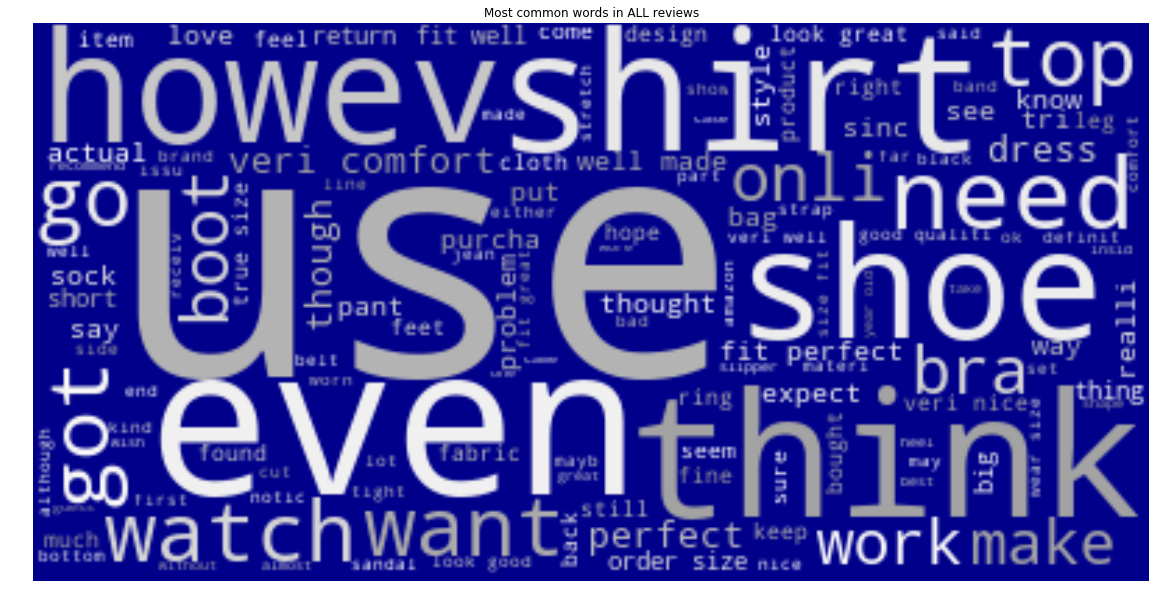

In [0]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
  return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

  
all_tokenlist = ddown[predictions_field + '_tokens']
sentences = (list(itertools.chain(all_tokenlist)))
flat_list = [item for sublist in sentences for item in sublist]

fig = plt.figure(figsize=(20,14))
wordcloud = WordCloud(background_color="darkblue").generate(" ".join(flat_list))
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in ALL reviews")



---



#### Positive reviews

Text(0.5, 1.0, 'Most common words in POSITIVE reviews')

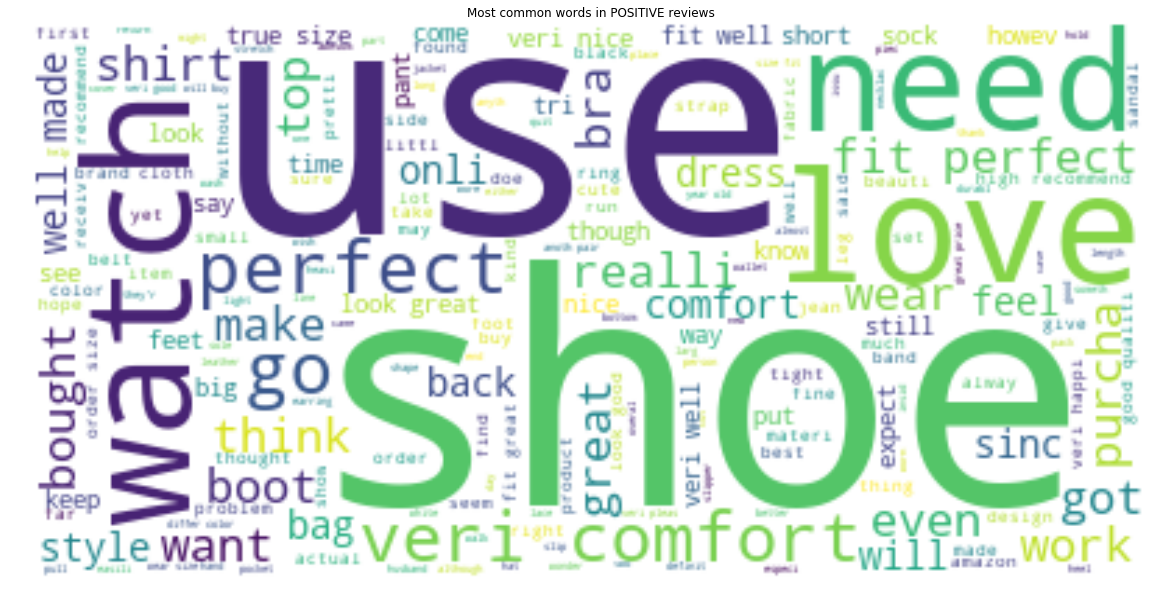

In [0]:
positive_tokenlist = ddown[ddown['sentiment'] == 'positive'][predictions_field + '_tokens']
sentences = (list(itertools.chain(positive_tokenlist)))
flat_list = [item for sublist in sentences for item in sublist]

fig = plt.figure(figsize=(20,14))
wordcloud = WordCloud(background_color="white").generate(" ".join(flat_list))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in POSITIVE reviews")

#### Negative reviews

Text(0.5, 1.0, 'Most common words in NEGATIVE reviews')

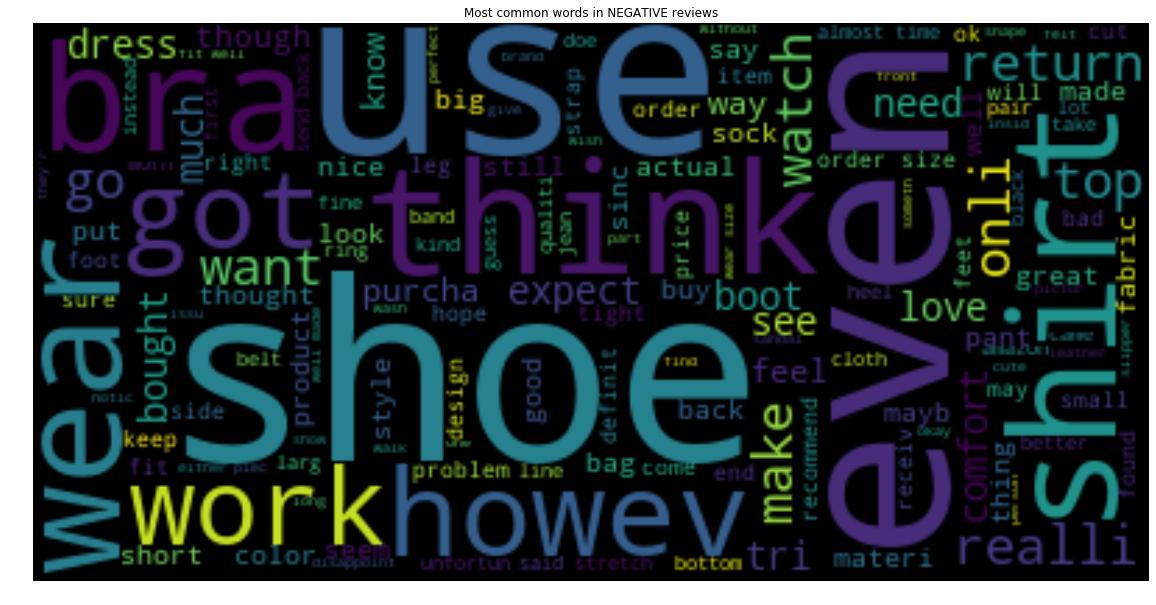

In [0]:
positive_tokenlist = ddown[ddown['sentiment'] == 'negative'][predictions_field + '_tokens']
sentences = (list(itertools.chain(positive_tokenlist)))
flat_list = [item for sublist in sentences for item in sublist]

fig = plt.figure(figsize=(20,14))
wordcloud = WordCloud(background_color="black").generate(" ".join(flat_list))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in NEGATIVE reviews")

#### Some considerations

From the previous images, it can be seen that some words are very common in both positive and negative reviews. These words should be removed from reviews while considering them for prediction, maybe adding less significant tokens into stopwords. However, this behaviour has been tested with following algorithm, and they seem to get better results even considering most common words such as "good" and "great" in reviews summaries. That is why stopwords will not be updated here.

In [0]:
# print("Before stopwords count: ", len(stopset))

# stopset.add('good')
# stopset.add('great')

# print("After stopwords count: ", len(stopset))

## Machine Learning

### TF-IDF (term frequency - inverse document frequency)

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect **how important a word is to a document in a collection or corpus**. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today. \- Wikipedia

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

ddown = ddown.drop(['rating'], axis = 1, errors = 'ignore') # directly infers sentiment

ddown['sentiment'] = [1 if s == 'positive' else 0 for s in ddown['sentiment']] # needed 0-1 by sklearn for k-fold cv


# Tf-idf settings
tvec = TfidfVectorizer(use_idf = True,
                       strip_accents = None, # already done
                       stop_words = None, # already done
                       lowercase = False) # already done

actuals = ddown.sentiment # truth
tfidf = tvec.fit_transform(ddown[predictions_field + '_normalized']) # learning vocabulary and idf

print("(rows,) \t=", actuals.shape) # truth
print("(rows, terms)\t=", tfidf.shape) # Tf-idf-weighted document-term matrix

(rows,) 	= (114160,)
(rows, terms)	= (114160, 33714)


### Term Weights

Common terms have higher weights in the resulting Tf-idf-weighted document-term matrix. If a term appears to be very frequent but not much significant, then it should be inserted in the stopwords list.

In [70]:
print("Most weighted terms")
weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

Most weighted terms


,term,weight
4121,but,0.040886
19248,not,0.037178
25748,size,0.033456
31509,veri,0.032994
10467,fit,0.032224
16499,look,0.030117
16151,like,0.029839
32213,wear,0.029403
25314,shoe,0.027903
16656,love,0.025427


Overall, in all datasets one of the most important terms are "good" and "great", both for positive and negative reviews. They are followed by the words "but" and "not", so it can be noticed a relationship between actually positive words and the use of negative adverbs and conjunctions.

### Splitting training and test set

Altough *Tf-idf-weighted document-term matrix* is learnt on the whole dataset, ML models must be run on splitted dataset for training and testing porposes.

In [0]:
from sklearn.model_selection import train_test_split

tfidf_train, tfidf_test, actuals_train, actuals_test = train_test_split(tfidf, actuals, test_size = 0.3, shuffle = True)

### Models

Several machine learning models will be tried out to predict `rating` from review `summary` or `text`.

In [0]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer

from sklearn import naive_bayes
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier



def roc_and_auc(model):  
  
  pred_probs = model.predict_proba(tfidf_test)[:,1] # prediction probabilities for positive class
  
  auc = metrics.roc_auc_score(actuals_test, pred_probs)
  
  fpr, tpr, thresholds = metrics.roc_curve(actuals_test, pred_probs, pos_label = 1)
  plt.figure()
  plt.plot(fpr, tpr, label = 'AUROC = %0.4f' % auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.title('ROC Curve')
    

    
    
def run_model(model, folds = 10):
  
  print(model)
  print()
  
  # LEARNING AND PREDICTION
  
  model.fit(tfidf_train, actuals_train)
  predictions = model.predict(tfidf_test)
  
  
  # CONFUSION MATRIX
  
  df_confusion = pd.crosstab(actuals_test, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
  print("Confusion matrix\n", df_confusion)
  
  cm = metrics.confusion_matrix(actuals_test, predictions)
  plt.matshow(cm)
  plt.title('Confusion matrix')
  plt.colorbar()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  
  print("\n METRICS")
  print(metrics.classification_report(actuals_test, predictions))
  
  
  # ROC/AUC
  roc_and_auc(model)
  
  
  # CROSS VALIDATION
  
  print()
  accuracy = cross_val_score(model, tfidf, actuals, cv=folds, scoring='accuracy')
  print("ACCURACY ON %.0f FOLD CROSS VALIDATION: \t %0.4f (std deviation %0.6f)" % (folds, accuracy.mean(), accuracy.std()))
  precision = cross_val_score(model, tfidf, actuals, cv=folds, scoring='precision')
  print("PRECISION ON %.0f FOLD CROSS VALIDATION: \t %0.4f (std deviation %0.6f)" % (folds, precision.mean(), precision.std()))
  recall = cross_val_score(model, tfidf, actuals, cv=folds, scoring='recall')
  print("RECALL ON %.0f FOLD CROSS VALIDATION: \t %0.4f (std deviation %0.6f)" % (folds, recall.mean(), recall.std()))
  f1 = cross_val_score(model, tfidf, actuals, cv=folds, scoring='f1')
  print("F1 ON %.0f FOLD CROSS VALIDATION: \t %0.4f (std deviation %0.6f)" % (folds, f1.mean(), f1.std()))
  
  print("\n")

#### Naive Bayes

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix
 Predicted      0      1    All
Actual                        
0          14302   2817  17119
1           3702  13427  17129
All        18004  16244  34248


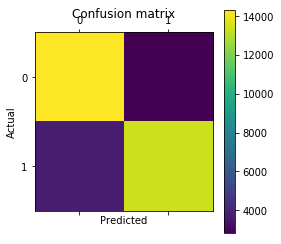


 METRICS
              precision    recall  f1-score   support

           0       0.79      0.84      0.81     17119
           1       0.83      0.78      0.80     17129

    accuracy                           0.81     34248
   macro avg       0.81      0.81      0.81     34248
weighted avg       0.81      0.81      0.81     34248


ACCURACY ON 10 FOLD CROSS VALIDATION: 	 0.8015 (std deviation 0.007751)
PRECISION ON 10 FOLD CROSS VALIDATION: 	 0.8116 (std deviation 0.014807)
RECALL ON 10 FOLD CROSS VALIDATION: 	 0.7858 (std deviation 0.007262)
F1 ON 10 FOLD CROSS VALIDATION: 	 0.7984 (std deviation 0.006062)


CPU times: user 3.54 s, sys: 208 ms, total: 3.75 s
Wall time: 3.51 s


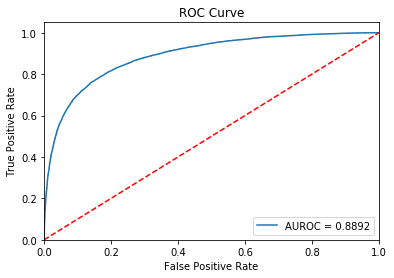

In [90]:
  bayes = naive_bayes.MultinomialNB()
  %time run_model(bayes)

#### SVM

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Confusion matrix
 Predicted      0      1    All
Actual                        
0          14580   2539  17119
1           3119  14010  17129
All        17699  16549  34248


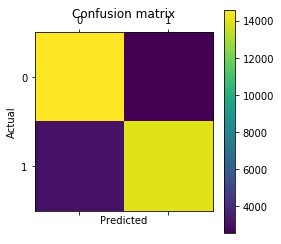


 METRICS
              precision    recall  f1-score   support

           0       0.82      0.85      0.84     17119
           1       0.85      0.82      0.83     17129

    accuracy                           0.83     34248
   macro avg       0.84      0.83      0.83     34248
weighted avg       0.84      0.83      0.83     34248


ACCURACY ON 10 FOLD CROSS VALIDATION: 	 0.8290 (std deviation 0.005217)
PRECISION ON 10 FOLD CROSS VALIDATION: 	 0.8371 (std deviation 0.009706)
RECALL ON 10 FOLD CROSS VALIDATION: 	 0.8176 (std deviation 0.008412)
F1 ON 10 FOLD CROSS VALIDATION: 		 0.8273 (std deviation 0.004608)


CPU times: user 21.7 s, sys: 3.99 s, total: 25.7 s
Wall time: 20.5 s


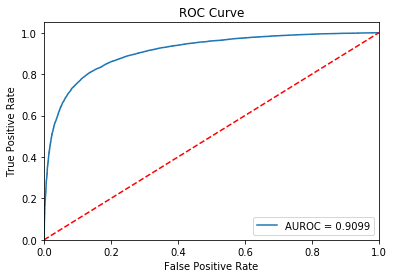

In [87]:
svm = SGDClassifier(loss='log')
%time run_model(svm)

#### Random Forest

Random Forest is slow and performs worse than the other models.

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Confusion matrix
 Predicted      0      1    All
Actual                        
0          12577   4542  17119
1           4765  12364  17129
All        17342  16906  34248


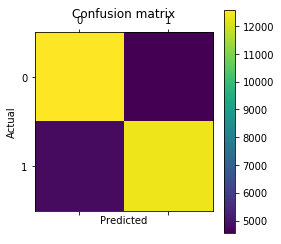


 METRICS
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     17119
           1       0.73      0.72      0.73     17129

    accuracy                           0.73     34248
   macro avg       0.73      0.73      0.73     34248
weighted avg       0.73      0.73      0.73     34248


ACCURACY ON 10 FOLD CROSS VALIDATION: 	 0.7327 (std deviation 0.005981)
PRECISION ON 10 FOLD CROSS VALIDATION: 	 0.7348 (std deviation 0.009141)
RECALL ON 10 FOLD CROSS VALIDATION: 	 0.7199 (std deviation 0.008359)
F1 ON 10 FOLD CROSS VALIDATION: 		 0.7279 (std deviation 0.003274)


CPU times: user 17min 17s, sys: 601 ms, total: 17min 18s
Wall time: 17min 18s


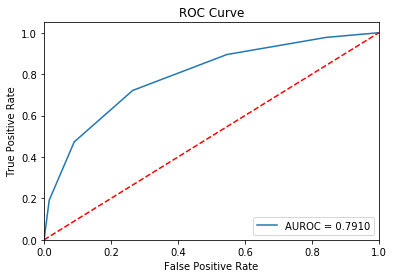

In [88]:
forest = RandomForestClassifier(n_estimators = 5) # default n_estimators is 10
%time run_model(forest, folds = 10)

### Prediction pipeline

This is the pipeline exported to use the model outside of this notebook. Trained model will be used by external programs, such as GUIs, in order to predict whether the user's written review is positive or negative. This is not dependant on NTLK anymore, text analysis is computed directly from sklearn.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

ddown = ddown.drop(['rating'], axis = 1, errors = 'ignore') # directly infers sentiment

# Tf-idf settings
text_clf = Pipeline([
  ('vect', TfidfVectorizer(use_idf = True,
                   strip_accents = 'ascii',
                   stop_words = stopset,
                   lowercase = True)),
  ('tfidf', TfidfTransformer()),
  ('clf', SGDClassifier(loss='log')),
])

**Training**

In [92]:
from sklearn.model_selection import train_test_split

train, test, actuals_train, actuals_test = train_test_split(ddown[predictions_field], ddown.sentiment, test_size = 0.3, shuffle = True)

text_clf.fit(train, actuals_train)
predicted = text_clf.predict(test)

print('Accuracy', np.mean(predicted == actuals_test))

Accuracy 0.833537724830647


In [93]:
text_clf.predict(['bad kitchen sold on amazon', 'this camera is pretty great', 'i will surely buy it again', 'not as good as expected'])

array([0, 1, 1, 0])

#### Saving model

In [0]:
# from google.colab import drive
# from joblib import dump, load

# drive.mount('/content/drive')
# drivepath = '/content/drive/My Drive/Data Analytics/'

# dump(text_clf, drivepath + 'model.joblib')

---

## Conclusions

Overall, Naive Bayes and SVM act very well among all tested datasets. Random Forest is slower and even worse in results, so it might not be recommendable for Reviews Sentiment Analysis.

Although the considered domain concerns Amazon reviews, the implemented models could be the right choice for any reviews system. It is curious how well this Machine Learning models are able to produce good predictions even though some words are strongly used in all reviews, maybe preceded by negative abverbs and conjuctions for the negative ones.

TF-IDF, broadly used for Information Retrieval by search engines, is also useful for Machine Learning tasks which involve text analysis in a supervised learning context. Lastly, it has to be said that Python is a good choice to manage text, thanks to many well-documented and easy-to-use libraries which have all the main features for text analysis.



---



## Aspect based sentiment analysis

In [0]:
from textblob import TextBlob
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [0]:
wiki = TextBlob(dfull[predictions_field][1])
wiki

TextBlob("I bought this for my 4 yr old daughter for dance class, she wore it today for the first time and the teacher thought it was adorable. I bought this to go with a light blue long sleeve leotard and was happy the colors matched up great. Price was very good too since some of these go for over $15.00 dollars.")

In [0]:
wiki.tags

[('I', 'PRP'),
 ('bought', 'VBD'),
 ('this', 'DT'),
 ('for', 'IN'),
 ('my', 'PRP$'),
 ('4', 'CD'),
 ('yr', 'RB'),
 ('old', 'JJ'),
 ('daughter', 'NN'),
 ('for', 'IN'),
 ('dance', 'NN'),
 ('class', 'NN'),
 ('she', 'PRP'),
 ('wore', 'VBD'),
 ('it', 'PRP'),
 ('today', 'NN'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('first', 'JJ'),
 ('time', 'NN'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('teacher', 'NN'),
 ('thought', 'VBD'),
 ('it', 'PRP'),
 ('was', 'VBD'),
 ('adorable', 'JJ'),
 ('I', 'PRP'),
 ('bought', 'VBD'),
 ('this', 'DT'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('with', 'IN'),
 ('a', 'DT'),
 ('light', 'JJ'),
 ('blue', 'NN'),
 ('long', 'RB'),
 ('sleeve', 'JJ'),
 ('leotard', 'NN'),
 ('and', 'CC'),
 ('was', 'VBD'),
 ('happy', 'JJ'),
 ('the', 'DT'),
 ('colors', 'NNS'),
 ('matched', 'VBD'),
 ('up', 'RP'),
 ('great', 'JJ'),
 ('Price', 'NN'),
 ('was', 'VBD'),
 ('very', 'RB'),
 ('good', 'JJ'),
 ('too', 'RB'),
 ('since', 'IN'),
 ('some', 'DT'),
 ('of', 'IN'),
 ('these', 'DT'),
 ('go', 'NNS'),
 ('for', 'IN'),
 ('o

In [0]:
wiki.noun_phrases

WordList(['old daughter', 'dance class', 'sleeve leotard', 'price'])

In [0]:
# def analyze_aspect(text):

#   blob=TextBlob(text)
#   tokens=list(blob.words)

#   print("Global polarity: ", blob.polarity)

#   word=[]
#   sent=[]
#   c=0
#   i=0

#   # JJ = adjective
#   # JJR = comparitive adjective
#   # NN = noun
#   # NNS = noun plural

#   for words,pos in blob.tags:
#     if pos=='JJ' or pos=='NN' or pos=='JJR' or pos=='NNS':
#         word.append(words)
  
#   if len(word)>=2:
#     for i in range(len(word)):
#       if len(word)>=2:
#         firstw=word[0]
#         secw=word[1]
#         word.remove(firstw)
#         word.remove(secw)
#         findx=tokens.index(firstw)
#         lindx=tokens.index(secw)
#         partialsent = ' '.join(tokens[findx:lindx+1])
#         sent.append(partialsent)

#   # print()
#   # print("sent: ", sent)
#   # print("tokens: ",tokens)

#   for sentence in sent:
#     print(sentence,TextBlob(sentence).polarity)
  
  

# dataset = dfull[dfull['rating'] < 4]
# for i in range(int(10)):
#   rating = dataset['rating'][i]
#   sentence = dataset[predictions_field][i]
#   print('\n\n',rating, sentence)
#   try:
#     analyze_aspect(sentence)
#   except:
#     print("Error")